# Projet d'optimisation pour du "task offloading" avec Levy Flight

## Problème d'optimisation

Le problème d'optimisation fait suite à l'amélioration exponentielle du Big Data, (IOT, véhicules autonomes ...) qui font que le nombre de données en temps réel est de plus en plus important. Le nombre de données en temps réel (flux) devant être traitées rapidement a explosé.

Les clouds fournient de nombreuses ressources pour des calculs massifs. Cependant, les clouds centralisées sont surchargés par les flux de données, ce qui entraîne une consommation d'énergie importante et des retards.

C'est pour cette raison que l'on utilise désormais le fog computing, dont l'architecture permet de déterminer où le calcul doit être effectué : sur la machine locale, sur le fog layer ou sur le cloud. Le fog layer comprend des
routeurs, des commutateurs et des micro-serveurs (fog node) qui sont plus proches de la machine locale que le cloud, et qui peuvent être utilisés par les utilisateurs. 

Notre objectif est de développer un programme qui associe les fognode fN aux tâches à effectuer.

Nous avons pour cela modéliser notre problème comme suit :

$$\min\limits_{X_i} \sum\limits_{i = 1}^N X_i\frac{P_i-P^{min}}{P^{max}-P^{min}}$$
$$\min\limits_{X_i} \sum\limits_{i = 1}^N X_i\frac{D_i-D^{min}}{D^{max}-D^{min}}$$
$$ s.t. \sum\limits_{i = 1}^N X_i-M=0$$
$$\sum\limits_{i = 1}^N \frac{B_i}{B_{i,S}} \quad \quad - 1 < 0 \\$$
$$W_j \in [0,1], \forall j \in \{1, 2, 3\}\\$$
$$T_{j,i} \in [0,1], \forall j \in \{1, 2, 3\}, \forall i \in [\![1, N]\!]\\$$
$$X_i \in \{0,1\}, \forall i \in [\![1, N]\!]\\$$

$P_i = P_i*\frac{l\tau_i}{f_i}$ la puissance pour traiter l bit de donnée sachant que 1 bit de donnée est traités sur $\tau_i$ cycle de CPU sur la fréquence du CPU (afin de déterminer le temps de calcul nécessaire pour l bits) fois la puissance requise pour un cycle $P_i*$. $P^{min}$ et $D^{min}$ représentent respectivement les FN de tout le système avec la plus petite puissance consommé et le retard le plus court, à l'inverse, $P^{max}$ et $D^{max}$ représentent respectivement les FN de tout le système avec la plus grande puissance consommé et le retard le plus long, le but est de normalisé les valeurs. 

$D_i$ est déterminé avec des courbe de service d'entré et de sortie déterminé par du calcul de réseau.

La première fonction objectif permet de minimiser la puissance consommé lors dans l'assignation. La seconde contrainte est la minimisation du retard totale du système. La première contrainte permet d'allouer exactement M FN au M taches. La quatrième permet de vérifier que la taille de traitement d'opération disponible dans le FN (buffer $B_{i,S}$) est suffisante pour traiter la taille de la tache $B_i$. 

Or ce problème suppose que le problème d'allocation d'une tache à un FN signifie que tous les FN ne seront pas alloué et que toutes les tâches soient les mêmes, c'est à dire : pour 4 sous taches répparti sur 7 FN disponibles, je dois trouver une solution de la forme [1, 1, 1, 1, 0, 0, 0] optimal. Cependant, nous voyons clairement sur la recherche que pour des FN identiques assignés à des tâches différentes, la valeur d'assignement est différente : 

<img src="Images/table_assignement_FN.PNG" alt="assignement FN" height="300" />


Ce qui signifie que chaque tâches réparties entre les FN ont des caractéristiques différentes.

C'est pour cette raison que nous cherchons plutôt à modéliser les solutions sous la forme d'un tableau de toutes les tâches alloués au FN choisi de la forme [FN1, FN3, FN4, FN2, FN1] ou le premier indice indique la première tâche et le nième indice indique la nième tâche.

Nous pouvons donc réécrire le problème :

$$\min\limits_{X_{i,j}} \sum\limits_{i = 1}^N X_{i,j}P_{i,j}$$
$$\min\limits_{X_{i,j}} \sum\limits_{i = 1}^N X_{i,j}D_{i,j}$$
$$ s.t. \sum\limits_{i = 1}^N X_{i,j}-M=0$$
$$\sum\limits_{i = 1}^N \frac{B_{i,j}}{B_{i,j,S}} \quad \quad - 1 < 0 \\$$
$$\sum\limits_{i = 1}^N X_{i,j} = \sum\limits_{j = 1}^M X_{i,j} = 1\\$$
$$X_i \in \{0,1\}, \forall i \in [\![1, N]\!]\\$$


Ainsi nous travaillerons sur un environnement similaire fournis par les tableau de Cost et de temps d'éxecution. Nous supposerons aussi que la contrainte du buffer est naturellement respectée.

## Algorithme d'optimisation Levy Flight

Cet algorithme s'inspire du comportement erratique des animaux lorsqu'ils cherchent de la nourriture en faisant des petit pas puis des grand pas moins souvent pour modifier l'environnement total. En imitant ce comportement, notre algorithme cherche à ne pas rester coincé dans des minimum locaux.


<img src="Images/levy_flight_animal.PNG" alt="Levy Flight" height="300" />

Pour faire correspondre l'algorithme Levy Flight au problème spécifique, Nous avons défini les étapes de process comme suit :

- Générer une solution aléatoire avec un tableau de N indice (pour N tâches) avec un FN attitré
- Générer un nombre aléatoire selon une gaussienne 
    - si ce nombre est petit alors faire peu de modifications aléatoires
    - si ce nombre est grand alors faire beaucoups de modifications aléatoires à la fois
- Évaluer la nouvelle solution
- Si cette solution n'est pas dominé par les anciennes solutions, la rajouter au solution non dominé
- Si cette solution domine des solutions déjà enregistrée, retirer les anciennes solutions
- Critère d'arrêt : Nombre de solution non dominé suffisamment nombreuse pour créer le front pareto

La principale caractéritisque de cette méthode est le nombre de modification de la solution que l'on effectue suivant les probabilité d'une gaussienne qui s'inspire de la probabilité d'un oiseau de faire des grands sauts,  plus le nombre aléatoire est éloigné de la moyenne établie, plus la probabilité de randomiser toute la solution existante est grande.





In [4]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time

## Deux datasets CostTable et ExecutionTable

CostTable représente le cout énergétique d'éxécuter chaque tâche sur chacun des FN.

ExecutionTable représente le délai d'éxecution de chaque tâche sur chaque FN.



In [5]:
cost_table = np.genfromtxt('Dataset/CostTable40.csv', delimiter=',', skip_header=1)
cost_table = cost_table[:, 1:] # clean le dataset
execution_table = np.genfromtxt('Dataset/ExecutionTable40.csv', delimiter=',', skip_header=1)
execution_table = execution_table[:, 1:] # clean le dataset

On retiendra dans notre algorithme divers solutions tant qu'elle seront non dominé pour créer un front pareto

In [6]:
Solutions_retenues = []

In [7]:
# Génerer une allocation aléatoire en donnant une liste de même temps que le nombre de tâche
def generate_allocation(allocation: list):
    for i in range (0, len(cost_table[0])):
        allocation[i] = np.random.randint(1, len(cost_table)+1)


On crée une fonction qui évalue le cout de notre allocation et une fonction qui évalue le temps total.

Le temps total est évalué comme suit : Chaque Tache rentrera à peu près en même temps dans tous les FN donc le délai total du système correspond au délai du FN qui prendra le plus de retard:

$D = max({D_i}  \forall i \in M)$

In [8]:
# fonction pour évaluer la solution sur la fonction objectif de consommation de puissance
def cost(allocation):
    Total_Cost = 0
    for i in range(len(allocation)):
        task = i
        node = allocation[i] -1
        Total_Cost += cost_table[node, task]
    return Total_Cost

# fonction pour évaluer la solution sur la fonction objectif de temps
def delay(allocation):
    Total_Time, N1_Time, N2_Time, N3_Time, N4_Time, N5_Time, N6_Time, N7_Time, N8_Time, N9_Time, N10_Time, N11_Time, N12_Time, N13_Time = 0,0,0,0,0,0,0,0,0,0,0,0,0,0
    for i in range(len(allocation)):
        task = i
        node = int(allocation[i])
        if node == 1:
            N1_Time +=  execution_table[node -1, task]
        elif node == 2:
            N2_Time +=  execution_table[node -1, task]
        elif node == 3:
            N3_Time +=  execution_table[node -1, task]
        elif node == 4:
            N4_Time +=  execution_table[node -1, task]
        elif node == 5:
            N5_Time +=  execution_table[node -1, task]
        elif node == 6:
            N6_Time +=  execution_table[node -1, task]
        elif node == 7:
            N7_Time +=  execution_table[node -1, task]
        elif node == 8:
            N8_Time +=  execution_table[node -1, task]
        elif node == 9:
            N9_Time +=  execution_table[node -1, task]
        elif node == 10:
            N10_Time +=  execution_table[node -1, task]
        elif node == 11:
            N11_Time +=  execution_table[node -1, task]
        elif node == 12:
            N12_Time +=  execution_table[node -1, task]
        elif node == 13:
            N13_Time +=  execution_table[node -1, task]
    Total_Time = max(N1_Time, N2_Time, N3_Time, N4_Time, N5_Time, N6_Time, N7_Time, N8_Time, N9_Time, N10_Time, N11_Time, N12_Time, N13_Time)
    return Total_Time

## Créer une Gaussienne 
De cette manière, nous pouvons contrôler la distribution de la gaussienne visuellement.

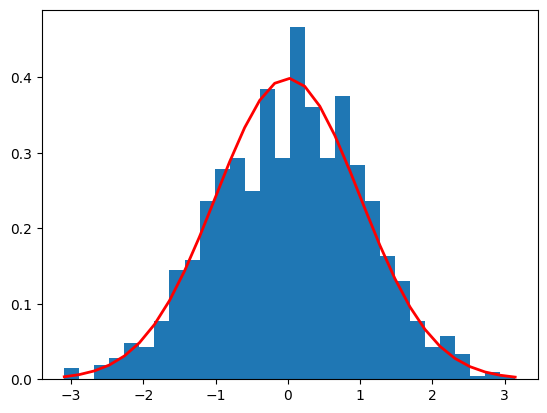

In [9]:
# visualisation de la gaussienne choisie
mu, sigma = 0, 1
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

## LEVY FLIGHT 
En fonction du pourcentage de chance de tirer une solution, on permet à chaque tâche d'être randomiser par un tirage qui doit être inférieur à n, plus les pas sont petits, plus n est petit, moins de transformations opèrent.

In [10]:
# modifier les valeurs dans les solutions
def shuffle_allocation(n, allocation):
    for i in range (0, len(cost_table[0])):
        # tirer un nombre au hasard entre 0 et 1
        tirage = np.random.rand()
        if tirage <= n:
            allocation[i] = np.random.randint(1, len(cost_table)+1)
        
# modifier notre solution par le levy flight    
def levyFlight(allocation):
    number = np.random.normal(mu, sigma)
    taux = abs(number)
    if taux > 3*sigma: #très grand normal 1% de chance
        generate_allocation(allocation)
    elif taux > 2*sigma: # grand pas 5% de chance
        shuffle_allocation(0.75, allocation)
    elif taux > sigma: # moyen pas
        shuffle_allocation(0.5, allocation)
    else: 
        shuffle_allocation(0.25, allocation)
    return allocation


## Solution généré par le Levy Flight

Une fois obtenue, la solution est testé pour savoir à quel rang elle appartient. Si elle est dans le front pareto, elle ne sera pas dominé et rejoindra les 20 solutions retenues, elle pourrait aussi retirer des solutions qu'elle dominera. Si elle est dominé par n'importe quelles autres solutions déjà retenues, alors elle ne sera pas utilisé.

In [11]:
# évaluer si la solution est dominée
def is_dominated(allocation1, allocation2):
    
    new_Total_Cost = cost(allocation1)
    new_Total_Time = delay(allocation1)
    old_Total_Cost = cost(allocation2)
    old_Total_Time = delay(allocation2)
    if new_Total_Cost > old_Total_Cost and new_Total_Time > old_Total_Time:
        return True
    else:
        return False
# série de test pour mettre à jour les solutions retenues
def TestSolution(New_Allocation, Solutions_retenues):
    for solution in Solutions_retenues:
        if is_dominated(New_Allocation, solution):
            return
        elif is_dominated(solution, New_Allocation):
            Solutions_retenues.remove(solution)
    Solutions_retenues.append(New_Allocation)
    


## INITIALISATION
On créer une allocation de task a des node aléatoire

In [12]:
First_allocation = [0] * len(cost_table[0])
generate_allocation(First_allocation) # première allocation généré aléatoirement
Solutions_retenues.append(First_allocation)

## Optimization
Depuis la dernière solution calculer : en générer une nouvelle.

Faire rentrer ou non cette solution parmi celles retenues

Critère d'arrêt : Générer 20 solutions non dominées. 

In [13]:
start_time = time.time()
while(len(Solutions_retenues) < 20): # On retient les 20 première meilleures solutions non dominées
    New_Allocation = deepcopy(First_allocation)
    New_Allocation = levyFlight(New_Allocation)
    TestSolution(New_Allocation, Solutions_retenues)
    First_allocation = deepcopy(New_Allocation)
end_time = time.time()

In [14]:
elapsed_time = end_time - start_time # calcul du temps de l'algorithme
print("Elapsed time: ", elapsed_time)

Elapsed time:  0.45459532737731934


## Visualisation 

Visuel du front pareto une fois le Levy Flight terminé

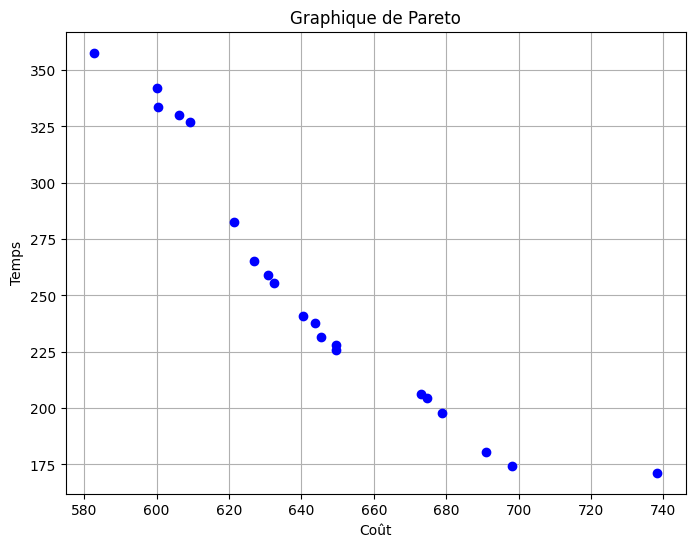

In [15]:
cost_pareto = []
time_pareto = []
for i in (Solutions_retenues):
    cost_pareto.append(cost(i))
    time_pareto.append(delay(i))

# Graphique de Pareto 
plt.figure(figsize=(8, 6))
plt.plot(cost_pareto, time_pareto, marker='o', linestyle='', color='b')  # En absisse le coût et en ordonnée le temps
plt.title('Graphique de Pareto')
plt.xlabel('Coût')
plt.ylabel('Temps')
plt.grid(True)
plt.show()

# Conclusion

Le levy Flight permet de généré un front pareto assez fluide en environ 2.5 secondes, les solutions sont bien répartie grace au saut long.
